In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import keras as K

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report, RocCurveDisplay

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

2024-11-14 01:04:57.863500: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-14 01:04:57.872749: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731564297.882173     861 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731564297.885166     861 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-14 01:04:57.897459: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Preparation for trainning - Train Split

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'Dataset of Breast mammography images with Masses/Image After Data Augmentation, Image Size 224x224/',
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(224, 224),
    batch_size=32,
)

Found 7632 files belonging to 8 classes.
Using 6106 files for training.


I0000 00:00:1731564301.102889     861 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1756 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [4]:
classes_ = train_ds.class_names
classes_

['Density1Benign',
 'Density1Malignant',
 'Density2Benign',
 'Density2Malignant',
 'Density3Benign',
 'Density3Malignant',
 'Density4Benign',
 'Density4Malignant']

In [5]:
classes_ = train_ds.class_names
len(classes_)

8

In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'Dataset of Breast mammography images with Masses/Image After Data Augmentation, Image Size 224x224/',
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(224, 224),
    batch_size=32,
)

Found 7632 files belonging to 8 classes.
Using 1526 files for validation.


In [7]:
def normalize(image, label):
  return tf.cast(image/255., tf.float32), label

train_ds = train_ds.map(normalize)
val_ds = val_ds.map(normalize)

train_ds, val_ds

(<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

# Preparation for trainning - Test Split

In [8]:
train_ds_test = tf.keras.preprocessing.image_dataset_from_directory(
    'Dataset of Breast mammography images with Masses/Image Before Data Augmentation, Image Size 224x224/',
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(224, 224),
    batch_size=32,
)

Found 212 files belonging to 8 classes.
Using 170 files for training.


In [9]:
val_ds_test = tf.keras.preprocessing.image_dataset_from_directory(
    'Dataset of Breast mammography images with Masses/Image Before Data Augmentation, Image Size 224x224/',
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(224, 224),
    batch_size=32,
)

Found 212 files belonging to 8 classes.
Using 42 files for validation.


In [10]:
def normalize(image, label):
  return tf.cast(image/255., tf.float32), label

train_ds_test = train_ds_test.map(normalize)
val_ds_test = val_ds_test.map(normalize)

train_ds_test, val_ds_test

(<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

# Training

In [11]:
from tensorflow.keras import mixed_precision


mixed_precision.set_global_policy('mixed_float16')

In [12]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

I0000 00:00:1731564302.308731     861 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1756 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [13]:
with session.as_default():
    base_model = EfficientNetB0(weights=None, include_top=True, input_shape=(224, 224, 3), classes=8)
    x = base_model.output
    x = Flatten()(x)
    last_layer = Dense(8, activation='softmax')(x)


2024-11-14 01:05:02.328000: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


In [14]:
model = tf.keras.Model(inputs=base_model.input, outputs=last_layer)

In [15]:
model.compile(optimizer='adam',
              loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])

In [16]:
epochs = 70
history = model.fit(train_ds,
                    validation_data=val_ds,
                    batch_size=64,
                    epochs=epochs)

Epoch 1/70


I0000 00:00:1731564322.343435     961 service.cc:148] XLA service 0x7fbcb0002630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731564322.343523     961 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-11-14 01:05:22.877110: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731564325.244343     961 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-14 01:05:33.488971: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=0} for conv (f16[32,14,14,480]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,14,14,480]{3,2,1,0}, f16[480,5,5,1]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=b01f_o01i->b01f, feature_group_count=480, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode

190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.1301 - loss: 2.0023

E0000 00:00:1731564393.250329     960 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731564393.608334     960 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731564394.794018     960 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731564395.107527     960 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731564397.362492     960 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.1304 - loss: 2.0020

E0000 00:00:1731564439.201550     954 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731564439.442152     954 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-11-14 01:07:19.756905: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=0} for conv (f16[22,14,14,672]{3,2,1,0}, u8[0]{0}) custom-call(f16[22,14,14,672]{3,2,1,0}, f16[672,5,5,1]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=b01f_o01i->b01f, feature_group_count=672, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
E0

191/191 ━━━━━━━━━━━━━━━━━━━━ 143s 398ms/step - accuracy: 0.1308 - loss: 2.0017 - val_accuracy: 0.1094 - val_loss: 2.0952
Epoch 2/70
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.2875 - loss: 1.8309 - val_accuracy: 0.3028 - val_loss: 1.7858
Epoch 3/70
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.2906 - loss: 1.7707 - val_accuracy: 0.3028 - val_loss: 1.7674
Epoch 4/70
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.3023 - loss: 1.7524 - val_accuracy: 0.3473 - val_loss: 1.7434
Epoch 5/70
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.3243 - loss: 1.7528 - val_accuracy: 0.2903 - val_loss: 1.8474
Epoch 6/70
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.3244 - loss: 1.7485 - val_accuracy: 0.3028 - val_loss: 1.8603
Epoch 7/70
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.3138 - loss: 1.7609 - val_accuracy: 0.3132 - val_loss: 1.7411
Epoch 8/70
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.3146 - loss: 1.7389 - val_accur

# Evaluating

In [17]:
history.history

{'accuracy': [0.19489027559757233,
  0.28725844621658325,
  0.2967572808265686,
  0.3049459457397461,
  0.31952178478240967,
  0.31870290637016296,
  0.3157550096511841,
  0.3128070831298828,
  0.3245987594127655,
  0.3083851933479309,
  0.3037995398044586,
  0.3111693561077118,
  0.31346216797828674,
  0.31624630093574524,
  0.31149688363075256,
  0.3309859037399292,
  0.33786439895629883,
  0.32246971130371094,
  0.2975761592388153,
  0.3010154068470001,
  0.32492631673812866,
  0.33573535084724426,
  0.33688175678253174,
  0.33753684163093567,
  0.3236161172389984,
  0.3255814015865326,
  0.3326236605644226,
  0.3362266719341278,
  0.33966588973999023,
  0.33589911460876465,
  0.3347527086734772,
  0.32869309186935425,
  0.3319685459136963,
  0.34752702713012695,
  0.33688175678253174,
  0.332787424325943,
  0.3408123254776001,
  0.34032100439071655,
  0.3388470411300659,
  0.3309859037399292,
  0.3105142414569855,
  0.31706517934799194,
  0.31706517934799194,
  0.3119882047176361,


In [18]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ cast[0][0]        │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ normalization[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 12,095,633 (46.14 MB)

 Trainable params: 4,017,868 (15.33 MB)

 Non-trainable params: 42,023 (164.16 KB)

 Optimizer params: 8,035,742 (30.65 MB)

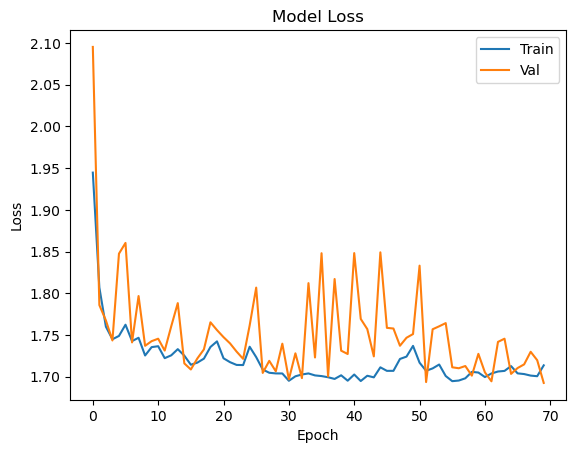

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

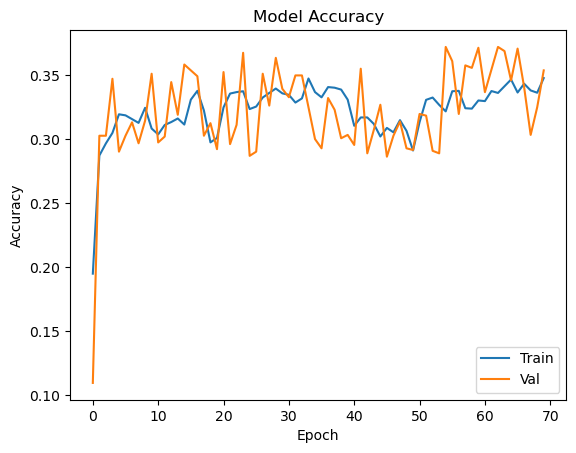

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [21]:
test_loss, test_acc = model.evaluate(val_ds, verbose=2)

48/48 - 1s - 16ms/step - accuracy: 0.3539 - loss: 1.6926


In [22]:
print(test_acc)

0.353866308927536


In [23]:
predictions = model.predict(train_ds_test)
val_pred = np.argmax(predictions, axis=1)

4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step

2024-11-14 01:22:05.544912: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=0} for conv (f16[10,14,14,672]{3,2,1,0}, u8[0]{0}) custom-call(f16[10,14,14,672]{3,2,1,0}, f16[672,5,5,1]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=b01f_o01i->b01f, feature_group_count=672, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
E0000 00:00:1731565325.635928     949 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731565325.986332     949 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
20

6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step


In [24]:
y_true = []
y_pred = []
for images, labels in val_ds_test:
  # Make predictions on the batch
  batch_pred = model.predict(images)
  y_pred.extend(list(batch_pred.argmax(axis=1)))  # Predicted labels
  y_true.extend(list(labels.numpy()))  # True labels from the batch

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


2024-11-14 01:22:17.581245: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


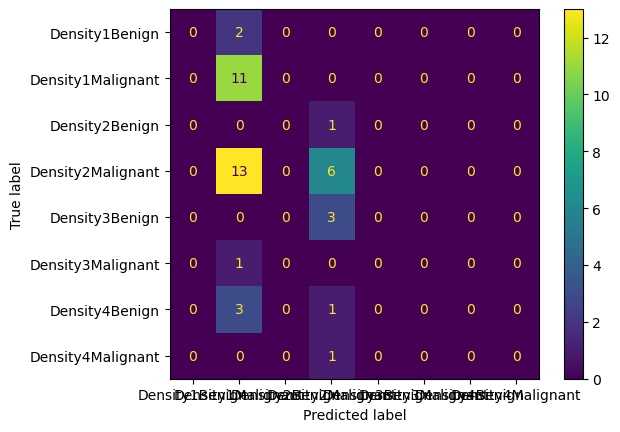

In [25]:
disp = ConfusionMatrixDisplay(cm, display_labels=classes_,)
disp.plot()

In [26]:
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.37      1.00      0.54        11
           2       0.00      0.00      0.00         1
           3       0.50      0.32      0.39        19
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         1

    accuracy                           0.40        42
   macro avg       0.11      0.16      0.12        42
weighted avg       0.32      0.40      0.32        42



/home/viviane/apps/anaconda3/envs/pro1-cnn/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/viviane/apps/anaconda3/envs/pro1-cnn/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/viviane/apps/anaconda3/envs/pro1-cnn/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [36]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import matplotlib.pyplot as plt


# Carregar um modelo pré-treinado ResNet50
# model = ResNet50(weights='imagenet')

img_path = 'Dataset of Breast mammography images with Masses/Image Before Data Augmentation, Image Size 224x224/Density2Benign/20586960.png'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)


preds = model.predict(x)
# print('Predicted:', decode_predictions(preds, top=3)[0])


def generate_class_activation_heatmap(model, img_path, layer_name='block4_pool'):
   
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = model(x)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()    # ... (código para gerar o mapa de calor usando a camada especificada)
    # ... (código adaptado da documentação do Keras)

# Gerar o mapa de calor utilizando CAM (exemplo simplificado)
heatmap = generate_class_activation_heatmap(model, img_path)

# Visualizar o mapa de calor sobre a imagem original
plt.imshow(img)
plt.imshow(heatmap, cmap='jet', alpha=0.4)
plt.colorbar()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


ValueError: not enough values to unpack (expected 2, got 1)

In [28]:
fpr = dict()
tpr = dict()
roc_auc = dict()
y_true = np.eye(8)[y_true]
for i in range(len(classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
for i in range(len(classes_)):
    RocCurveDisplay.from_predictions(y_true[:, i], y_pred[:, i], name=f"ROC curve of class {i}")

plt.legend()
plt.show()

TypeError: list indices must be integers or slices, not tuple

In [ ]:
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()